# Исследование сервиса аренды самокатов GoFast

## Описание данных

Имеются данные о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализировать данные и проверь некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 
Сервисом можно пользоваться:
- без подписки
абонентская плата отсутствует;
стоимость одной минуты поездки —  8 рублей;
стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
абонентская плата — 199 рублей в месяц;
стоимость одной минуты поездки — 6 рублей;
стоимость старта — бесплатно.

Для работы предаставлены три таблицы.
1. Пользователи
- user_id - уникальный идентификатор пользователя
- name -	имя пользователя
- age -	возраст
- city -	город
- subscription_type -	тип подписки (free, ultra)

2. Поездки
- user_id -	уникальный идентификатор пользователя
- distance -	расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration -	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date -	дата совершения поездки

3. Подписки 
- subscription_type -	тип подписки
- minute_price -	стоимость одной минуты поездки по данной подписке
- start_ride_price -	стоимость начала поездки
- subscription_fee -	стоимость ежемесячного платежа

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Шаг 1. Загрузка данных

In [2]:
#откроем датафрейм и выведем на экран первые 10 строк
data1 = pd.read_csv('/datasets/users_go.csv')
data1.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [3]:
data2 = pd.read_csv('/datasets/rides_go.csv')
data2.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [4]:
data3 = pd.read_csv('/datasets/subscriptions_go.csv')
data3.head(10)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


На первый взгляд все хорошо. Выведем общую информацию о таблицах

In [5]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В данной таблице нет пропусков и тип данных соответствует содержимому

In [6]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В этой таблице тоже нет пропусков. Однако, столбец date нужно преобразовать в datetime. Сделаем это в следующем шаге

In [7]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Здесь все хорошо, ничего трогать не будем.

## Шаг 2. Предобработка данных

В предыдушем шаге было обнаружено, что в одном столбце необходимо изменить тип данных. 

In [8]:
data2['date'] = pd.to_datetime(data2['date'], format='%Y.%m.%d')
data2.dtypes #проверим работу кода

user_id              int64
distance           float64
duration           float64
date        datetime64[ns]
dtype: object

Проверим таблицы на наличие дубликатов.

In [9]:
data1.duplicated().sum()

31

В данной таблице 31 дубликатов. Необходимо их удалить

In [10]:
data1 = data1.drop_duplicates().reset_index(drop=True) 
data1.duplicated().sum() #проверим строки на наличие дубликатов

0

Дубликаты устранены.

In [11]:
data2.duplicated().sum()

0

In [12]:
data3.duplicated().sum()

0

В двух последующих таблицах дубликаты отсутствуют.

## Шаг 3. Исследовательский анализ данных

Изучим общую информацию о пользователях и поездках. Для этого построим гисторгаммы.

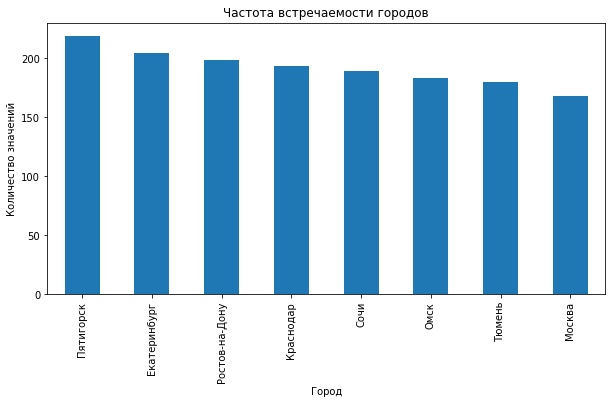

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [13]:
# частота встречаемости городов
data1['city'].value_counts().plot(kind='bar',figsize=(10, 5),)              
plt.xlabel('Город')
plt.ylabel('Количество значений')
plt.title('Частота встречаемости городов')
plt.show()
data1['city'].value_counts()

Как видно по выводимым данным сервис пользуется популярностью больше всего в Пятигорске и меньше всего в Москве.

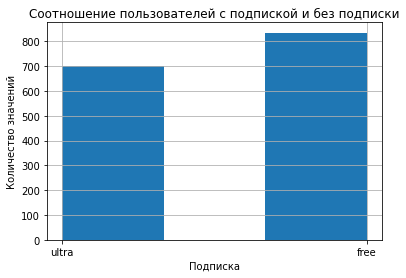

free     835
ultra    699
Name: subscription_type, dtype: int64

In [14]:
# соотношение пользователей с подпиской и без подписки
data1['subscription_type'].hist(bins=3)
plt.xlabel('Подписка')
plt.ylabel('Количество значений')
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.show()
data1['subscription_type'].value_counts()

In [15]:

ratio1=len(data1.query('subscription_type == "ultra"')) / len(data1)*100 
round(ratio1, 2)         

45.57

In [16]:
ratio2=len(data1.query('subscription_type == "free"')) / len(data1)*100 
round(ratio2, 2)  


54.43

45% пользователей подключили подписку, а 54% пользователей не предпочитают эту услугу

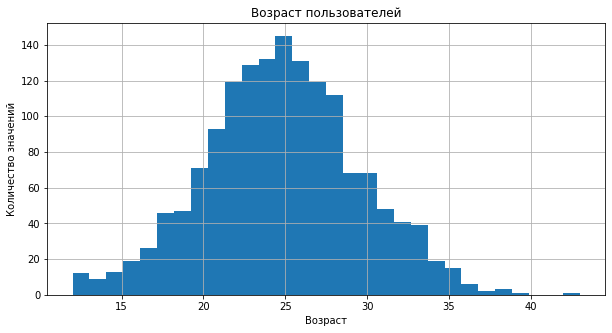

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [17]:
#возраст пользователей
data1['age'].hist(bins=30,  figsize=(10,5))
plt.xlabel('Возраст')
plt.ylabel('Количество значений')
plt.title('Возраст пользователей')
plt.show()

data1['age'].describe()

Средний возраст пользователей 25 лет.Самому младшему 12 лет, а старшему 43 года

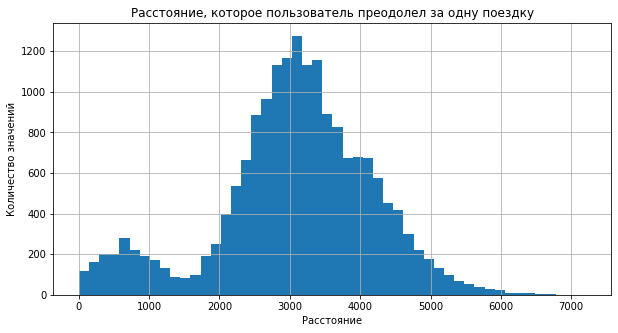

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

In [18]:
# расстояние, которое пользователь преодолел за одну поездку
data2['distance'].hist(bins=50,  figsize=(10,5))
plt.xlabel('Расстояние')
plt.ylabel('Количество значений')
plt.title('Расстояние, которое пользователь преодолел за одну поездку')

plt.show()
data2['distance'].describe()

В среднем пользователи проезжают 3км и максимум 7,2 км.  На графике два пика: небольшое количество людей проезжают до 1км, второй пик это наша медиана.

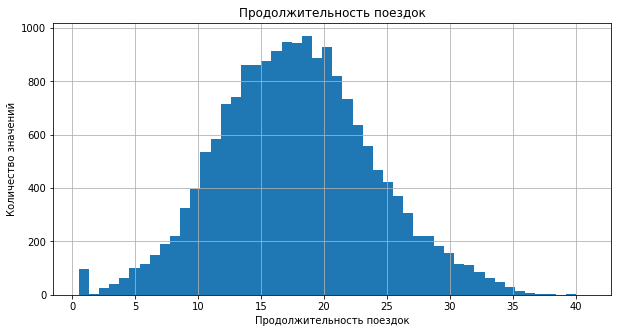

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [19]:
# продолжительность поездок
data2['duration'].hist(bins=50,  figsize=(10,5))
plt.xlabel('Продолжительность поездок')
plt.ylabel('Количество значений')
plt.title('Продолжительность поездок')
plt.show()
data2['duration'].describe()

В среднем пользователи проезжают 17 минут и максимум 40 минут.  На графике в значении примерно 1-2 минуты есть небольшой пик. Скорее всего это время, за которое некоторые пользователи настраивали самокат "под себя".

В ходе работы по исследованию данных можно сделать следующие выводы:
- Больше всего пользователей в Пятигорске, а меньше в Москве;
- Почти половина пользователей подключили подписку;
- Самокатами пользуются в основном молодежь;
- Поездка на самокате длится в среднем 17 минут и около 3 км.

## Шаг 4. Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм

In [20]:
data4=data1.merge(data2, on='user_id') 
data=data4.merge(data3, on='subscription_type') 
data.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,6,0,199


In [21]:
data.shape #проверим количество строк

(18068, 11)

Самая длинная таблица была data2, в нем было 18068 строк. Метод shape вывел нам такое же количество строк и 11 столбцов. Все сходиться

 Создадим ещё два датафрейма из нового датафрейма data:
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.

In [22]:
#пользователи с подпиской
data_ultra=data[data['subscription_type']=='ultra']


In [23]:
#пользователи без подписки
data_free=data[data['subscription_type']=='free']


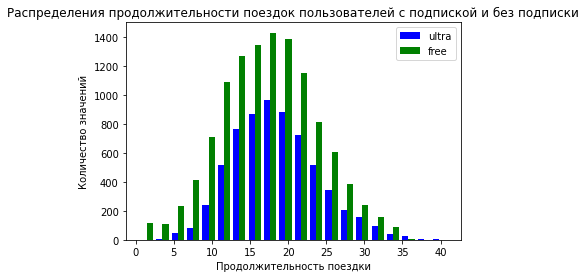

In [24]:
#сравним распределения продолжительности поездок пользователей с подпиской и без подписки
x1=list(data_ultra['duration'])
x2=list(data_free['duration'])
plt.hist([x1, x2], bins=20, color=['blue', 'green'], label=['ultra','free'])
plt.legend()
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество значений')
plt.title('Распределения продолжительности поездок пользователей с подпиской и без подписки')
plt.show()

График показывает, что пользователи без подписки пользуются самокатами побольше чем с подпиской.

## Шаг 5. Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма data: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [25]:
data['month'] = pd.DatetimeIndex(data['date']).month #создадим столбец с месяцами

In [26]:
data['duration'] = np.ceil(data['duration']) #округлим значение до следующего целого числа

In [27]:
data_pivot=data.pivot_table(index=['user_id','month'], values=['distance','duration', 'subscription_type'], aggfunc={'distance':'sum','duration':'sum','user_id': 'count', 'subscription_type':'min'})
data_pivot.columns = ['total_distance', 'total_duration', 'subscription_type', 'count']
data_pivot=data_pivot.reset_index()
data_pivot.head(20)

,user_id,month,total_distance,total_duration,subscription_type,count
0,1,1,7027.511294,42.0,ultra,2
1,1,4,754.159807,7.0,ultra,1
2,1,8,6723.470560,46.0,ultra,2
3,1,10,5809.911100,32.0,ultra,2
4,1,11,7003.499363,56.0,ultra,3
5,1,12,6751.629942,28.0,ultra,2
6,2,3,10187.723006,63.0,ultra,3
7,2,4,6164.381824,40.0,ultra,2
8,2,6,3255.338202,14.0,ultra,1
9,2,7,6780.722964,48.0,ultra,2


В результате получилась таблица с данными о каждом пользователе за все месяца.
В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь.

In [28]:
def income_def(row):
    total_duration=row['total_duration']
    total_distance=row['total_distance']
    count=row['count']
    subscription_type=row['subscription_type']
    
    if subscription_type=='ultra':
        return 6*total_duration+199
    if subscription_type=='free':
        return total_duration*8+count*50
data_pivot['income']=data_pivot.apply(income_def, axis=1)
data_pivot.head(15)   

,user_id,month,total_distance,total_duration,subscription_type,count,income
0,1,1,7027.511294,42.0,ultra,2,451.0
1,1,4,754.159807,7.0,ultra,1,241.0
2,1,8,6723.470560,46.0,ultra,2,475.0
3,1,10,5809.911100,32.0,ultra,2,391.0
4,1,11,7003.499363,56.0,ultra,3,535.0
5,1,12,6751.629942,28.0,ultra,2,367.0
6,2,3,10187.723006,63.0,ultra,3,577.0
7,2,4,6164.381824,40.0,ultra,2,439.0
8,2,6,3255.338202,14.0,ultra,1,283.0
9,2,7,6780.722964,48.0,ultra,2,487.0


По данной таблице можем наблюдать кто и сколько в каждый месяц принес доход сервису.

## Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов. Для проверки всех  гипотез будем использовать t-критерий Стьюдента.

**6.1**  Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. 

Проверим гипотезу  о равенстве средних двух генеральных совокупностей.  Альтернативная гипотеза:  средняя продолжительность времени на поездку (продолжительность сессии) у пользователей с подпиской больше средней продолжительность времени на поездку у пользователей без подписки. Нулевая гипотеза - меньше. Возьмем специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind (array1, array2, equal_var).

In [29]:
from scipy import stats as st
import numpy as np

sample_1= data_ultra['duration']
sample_2 = data_free['duration']

alpha = 0.05 # уровень статистической значимости

# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(sample_1, sample_2, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Р-value < 0.05, мы  можем отвергнуть нулевую гипотезу.Принимаем альтернативную гипотезу о том, что средняя продолжительность времени на поездку (продолжительность сессии) у пользователей с подпиской больше средней продолжительность времени на поездку у пользователей без подписки.

**6.2** Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим гипотезу и сделаем выводы.

Будем использовать односторонний тест. В Python нет специального метода для проведения одностороннего теста. Есть метод scipy.stats.ttest_1samp(), проверяющий двустороннюю гипотезу.  Так как нам нужен односторонний тест, выполним двусторонний, а выданное p-value просто поделим  пополам. Так мы получим одностороннюю вероятность отклонения наблюдаемого значения от предполагаемого.
Нулевая гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку равно оптимальному расстоянию с точки зрения износа самоката. 
Альтернативная гипотеза: среднее расстояние, которое меньше оптимального расстояния с точки зрения износа самоката.

In [30]:

id_ultra = data_ultra['distance']

prev_value = 3130

alpha = .05 # уровень статистической значимости

results = st.ttest_1samp(

    id_ultra, 

    prev_value)

# тест односторонний: p-value будет в два раза меньше

print('p-значение:', results.pvalue / 2)

# тест односторонний влево:

# отвергаем гипотезу только тогда, когда выборочное среднее значимо меньше предполагаемого значения

if (results.pvalue / 2 < alpha) and (id_ultra.mean() < prev_value):

    print("Отвергаем нулевую гипотезу")

else:

    print("Не отвергаем нулевую гипотезу")

p-значение: 0.08046311521502146
Не отвергаем нулевую гипотезу


Принимаем нулевую гипотезу. Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку равно оптимальному расстоянию с точки зрения износа самоката. 

**6.3** Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Для проверки гипотез также будем использовать t-критерий Стьюдента. Проверим гипотезу  о равенстве средних двух генеральных совокупностей.  
Нулевая гипотеза: средняя помесячная  выручка от пользователей с подпиской ниже средней помесячной выручки от пользователей без подписки. Альтернативная гипотеза: средняя помесячная  выручка от пользователей с подпиской выше средней помесячной выручки от пользователей без подписки. Также используем  scipy.stats.ttest_ind (array1, array2, equal_var).

In [31]:
data_ultra1=data_pivot[data_pivot['subscription_type']=='ultra']
data_free1=data_pivot[data_pivot['subscription_type']=='free']

sample_1= data_ultra1['income'] 
sample_2 = data_free1['income']

alpha = 0.05 # уровень статистической значимости

# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(sample_1, sample_2, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Р-value < 0.05, мы можем отвергнуть нулевую гипотезу. Принимаем альтернативную гипотезу о том, что средняя помесячная  выручка от пользователей с подпиской выше средней помесячной выручки от пользователей без подписки

**6.4** Представим, что техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Найдем тест, который понадобился бы для проверки этой гипотезы.

Здесь нам надо проверить гипотезу о равенстве средних двух генеральных совокупностей для зависимых (парных) выборок в Python, применим метод scipy.stats.ttest_rel().
Н0: Количество обращений в техподдержку до обновлений и после обновлений равно (не изменилось) . 
Н1: Количество обращений в техподдержку до обновлений и после обновлений не равно.

## Вывод

Была проделана большая работа по исследованию сервиса проката самокатов.

Мы сделали предобработку данных: в столбце date изменили тип; удалили дубликаты в таблице Пользователи; данные были полные, без пропусков. 

В ходе работы по исследованию данных можно сделать следующие выводы:
Больше всего пользователей в Пятигорске, а меньше в Москве;
Почти половина пользователей (45%) подключили подписку;
Самокатами пользуются в основном молодежь;
Поездка на самокате длится в среднем 17 минут и около 3 км.
создали сводные таблицы, построили графики, по которым провели анализ данных. Ответили на гипотезы, которые от нас требовали уточнить.

Для удобства мы объеденили таблицы Пользователи, Подписки и Поездку в один датафрейм. Затем создали сводную таблицу, где можно посмотреть кто сколько поехал и внес прибыли в каждом месяце. 

Проверили гипотезы, которые нам задали. 
Пользователи с подпиской тратят больше  времени на поездку и приносят больше выручки чем пользователи без подписки.
Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку равно оптимальному расстоянию с точки зрения износа самоката.

